In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk
#nltk.download('all')

# DATA READING

In [3]:
df = pd.read_csv('amazon-fine-food-reviews/Reviews.csv')
df = df.head(10000)
df.shape

(10000, 10)

In [4]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


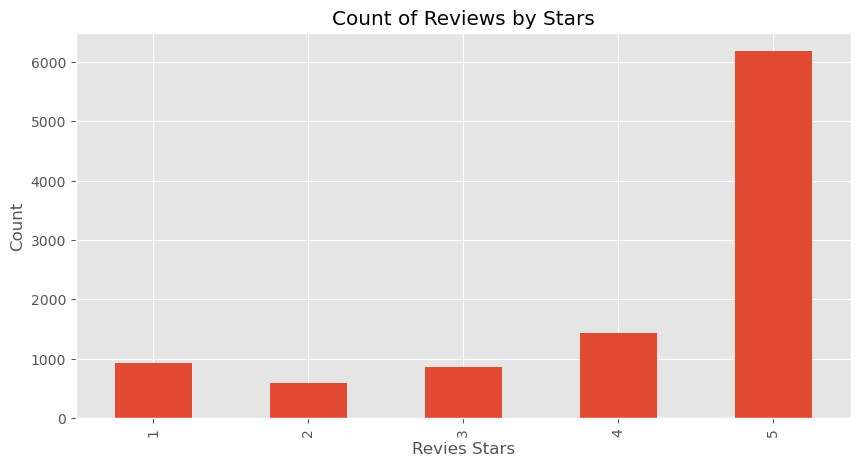

In [5]:
ax = df['Score'].value_counts().sort_index() \
    .plot(kind = 'bar', 
          title = "Count of Reviews by Stars",
          figsize = (10,5))
ax.set_xlabel('Revies Stars')
ax.set_ylabel('Count')
plt.show()

# BASIC NLTK

In [7]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [8]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [9]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [10]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


# VADER SENTIMENT SCORING

In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

sia = SentimentIntensityAnalyzer()

In [13]:
sia

In [14]:
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [15]:
#Running the polarity score on the entire dataset
res = {}

for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

100%|██████████| 10000/10000 [00:08<00:00, 1247.47it/s]


In [16]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {'index' : 'Id'})
vaders = vaders.merge(df, how = 'left')

In [17]:
# Now we have sentiment score and metadata
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# PLOT VADER RESULT

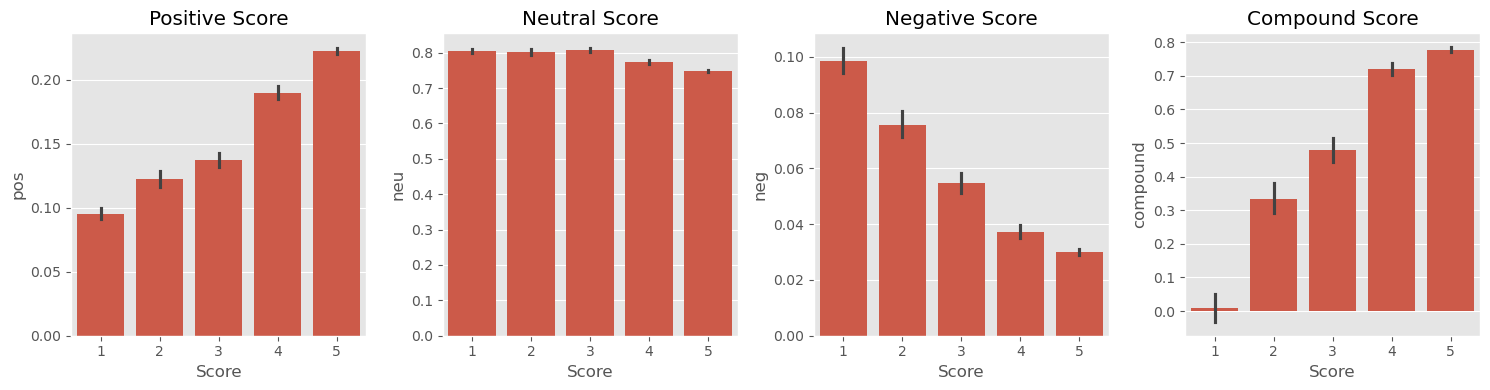

In [19]:
fig, axs = plt.subplots(1, 4, figsize = (15, 4))
sns.barplot(data = vaders, x = 'Score', y = 'pos', ax = axs[0])
sns.barplot(data = vaders, x = 'Score', y = 'neu', ax = axs[1])
sns.barplot(data = vaders, x = 'Score', y = 'neg', ax = axs[2])
sns.barplot(data = vaders, x = 'Score', y = 'compound', ax = axs[3])
axs[0].set_title('Positive Score')
axs[1].set_title('Neutral Score')
axs[2].set_title('Negative Score')
axs[3].set_title('Compound Score')
plt.tight_layout()
plt.show()

# Roberta Pretrained Model

In [21]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [23]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [24]:
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [25]:
encoded_text = tokenizer(example, return_tensors = 'pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
scores_dict

{'roberta_neg': 0.97635514,
 'roberta_neu': 0.020687466,
 'roberta_pos': 0.0029573692}

In [50]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [52]:
res = {}

for i, row in tqdm(df.iterrows(), total = len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  1%|          | 82/10000 [00:17<24:58,  6.62it/s]  

Broke for id 83


  2%|▏         | 188/10000 [00:43<28:30,  5.74it/s]  

Broke for id 187


  5%|▌         | 528/10000 [02:14<58:59,  2.68it/s]  

Broke for id 529


  5%|▌         | 539/10000 [02:17<34:29,  4.57it/s]

Broke for id 540


  7%|▋         | 745/10000 [03:19<1:12:21,  2.13it/s]

Broke for id 746


  9%|▊         | 864/10000 [03:51<30:20,  5.02it/s]  

Broke for id 863


 11%|█         | 1052/10000 [04:43<47:07,  3.16it/s]  

Broke for id 1053


 11%|█         | 1069/10000 [04:48<38:17,  3.89it/s]

Broke for id 1070


 12%|█▏        | 1157/10000 [05:12<17:16,  8.53it/s]  

Broke for id 1156


 13%|█▎        | 1320/10000 [05:50<40:05,  3.61it/s]  

Broke for id 1321


 14%|█▎        | 1374/10000 [06:00<51:25,  2.80it/s]

Broke for id 1375


 15%|█▍        | 1497/10000 [06:30<24:00,  5.90it/s]

Broke for id 1498


 16%|█▌        | 1574/10000 [06:50<59:19,  2.37it/s]

Broke for id 1575


 18%|█▊        | 1797/10000 [07:37<13:55,  9.81it/s]

Broke for id 1796


 18%|█▊        | 1827/10000 [07:43<23:00,  5.92it/s]

Broke for id 1826


 22%|██▏       | 2168/10000 [09:08<31:58,  4.08it/s]  

Broke for id 2169


 22%|██▏       | 2247/10000 [09:26<24:14,  5.33it/s]

Broke for id 2248


 25%|██▍       | 2475/10000 [10:23<38:39,  3.24it/s]

Broke for id 2476


 25%|██▍       | 2493/10000 [10:29<20:42,  6.04it/s]  

Broke for id 2492


 26%|██▌       | 2583/10000 [10:53<24:43,  5.00it/s]

Broke for id 2584


 26%|██▌       | 2609/10000 [11:00<44:22,  2.78it/s]

Broke for id 2610


 29%|██▉       | 2896/10000 [12:19<24:57,  4.74it/s]

Broke for id 2897
Broke for id 2898


 29%|██▉       | 2901/10000 [12:20<14:52,  7.95it/s]

Broke for id 2902


 29%|██▉       | 2927/10000 [12:27<47:19,  2.49it/s]

Broke for id 2928


 29%|██▉       | 2943/10000 [12:31<27:24,  4.29it/s]

Broke for id 2942
Broke for id 2944


 29%|██▉       | 2946/10000 [12:32<27:29,  4.28it/s]

Broke for id 2947
Broke for id 2948


 30%|███       | 3020/10000 [12:52<32:21,  3.60it/s]  

Broke for id 3022
Broke for id 3023


 30%|███       | 3024/10000 [12:52<21:23,  5.43it/s]

Broke for id 3025


 33%|███▎      | 3305/10000 [14:07<32:05,  3.48it/s]  

Broke for id 3306


 38%|███▊      | 3789/10000 [16:11<16:17,  6.36it/s]  

Broke for id 3788


 40%|███▉      | 3968/10000 [16:55<24:53,  4.04it/s]

Broke for id 3969


 41%|████      | 4108/10000 [17:36<22:49,  4.30it/s]

Broke for id 4107


 41%|████      | 4109/10000 [17:36<25:07,  3.91it/s]

Broke for id 4110


 43%|████▎     | 4306/10000 [18:34<29:23,  3.23it/s]

Broke for id 4307


 43%|████▎     | 4315/10000 [18:37<36:41,  2.58it/s]

Broke for id 4316


 44%|████▍     | 4409/10000 [19:00<15:37,  5.96it/s]

Broke for id 4408


 45%|████▍     | 4482/10000 [19:20<24:02,  3.82it/s]

Broke for id 4483


 45%|████▌     | 4511/10000 [19:30<26:00,  3.52it/s]

Broke for id 4512


 46%|████▌     | 4552/10000 [19:46<35:18,  2.57it/s]

Broke for id 4553


 46%|████▌     | 4582/10000 [20:00<38:49,  2.33it/s]

Broke for id 4583


 50%|█████     | 5039/10000 [22:28<29:14,  2.83it/s]

Broke for id 5040


 52%|█████▏    | 5181/10000 [28:01<15:49,  5.07it/s]    

Broke for id 5182


 52%|█████▏    | 5193/10000 [28:05<22:06,  3.62it/s]

Broke for id 5192


 54%|█████▎    | 5364/10000 [28:50<22:07,  3.49it/s]

Broke for id 5365


 54%|█████▍    | 5441/10000 [29:14<29:01,  2.62it/s]

Broke for id 5442


 57%|█████▋    | 5708/10000 [30:38<15:37,  4.58it/s]

Broke for id 5709


 60%|█████▉    | 5997/10000 [32:06<16:00,  4.17it/s]

Broke for id 5998


 60%|██████    | 6002/10000 [32:08<25:15,  2.64it/s]

Broke for id 6003


 60%|██████    | 6006/10000 [32:09<23:02,  2.89it/s]

Broke for id 6007


 61%|██████    | 6108/10000 [32:40<14:10,  4.57it/s]

Broke for id 6106


 62%|██████▏   | 6233/10000 [39:09<23:36,  2.66it/s]   

Broke for id 6234


 66%|██████▌   | 6557/10000 [40:43<24:24,  2.35it/s]

Broke for id 6558


 66%|██████▋   | 6650/10000 [41:14<23:26,  2.38it/s]

Broke for id 6651


 68%|██████▊   | 6799/10000 [42:20<17:51,  2.99it/s]

Broke for id 6798


 68%|██████▊   | 6837/10000 [42:37<24:37,  2.14it/s]

Broke for id 6838


 68%|██████▊   | 6849/10000 [42:42<25:11,  2.08it/s]

Broke for id 6850


 69%|██████▉   | 6885/10000 [42:54<16:04,  3.23it/s]

Broke for id 6886


 69%|██████▉   | 6906/10000 [43:00<14:27,  3.57it/s]

Broke for id 6905


 70%|██████▉   | 6954/10000 [43:16<15:39,  3.24it/s]

Broke for id 6955


 71%|███████   | 7076/10000 [43:47<13:18,  3.66it/s]

Broke for id 7077


 71%|███████   | 7087/10000 [43:49<09:55,  4.89it/s]

Broke for id 7088


 72%|███████▏  | 7200/10000 [44:18<09:00,  5.18it/s]

Broke for id 7201


 76%|███████▌  | 7605/10000 [45:56<07:17,  5.47it/s]

Broke for id 7604


 76%|███████▌  | 7607/10000 [45:56<08:15,  4.83it/s]

Broke for id 7608


 77%|███████▋  | 7672/10000 [46:10<06:52,  5.64it/s]

Broke for id 7671


 77%|███████▋  | 7700/10000 [46:23<18:28,  2.07it/s]

Broke for id 7701


 78%|███████▊  | 7809/10000 [46:51<11:03,  3.30it/s]

Broke for id 7810


 79%|███████▉  | 7908/10000 [47:16<08:54,  3.91it/s]

Broke for id 7907


 81%|████████  | 8076/10000 [48:07<08:16,  3.88it/s]

Broke for id 8077


 81%|████████▏ | 8130/10000 [48:21<09:44,  3.20it/s]

Broke for id 8131


 83%|████████▎ | 8265/10000 [49:00<11:41,  2.47it/s]

Broke for id 8266


 87%|████████▋ | 8739/10000 [51:00<05:56,  3.54it/s]

Broke for id 8740


 88%|████████▊ | 8756/10000 [51:05<04:13,  4.90it/s]

Broke for id 8757


 89%|████████▉ | 8934/10000 [51:55<04:15,  4.17it/s]

Broke for id 8935


 96%|█████████▌| 9589/10000 [54:36<03:37,  1.89it/s]

Broke for id 9590


 98%|█████████▊| 9849/10000 [55:59<01:09,  2.17it/s]

Broke for id 9850


 99%|█████████▉| 9880/10000 [56:07<00:36,  3.25it/s]

Broke for id 9881


 99%|█████████▉| 9909/10000 [56:16<00:45,  1.99it/s]

Broke for id 9910


 99%|█████████▉| 9922/10000 [56:21<00:25,  3.02it/s]

Broke for id 9923


100%|██████████| 10000/10000 [56:43<00:00,  2.94it/s]


In [54]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index' : 'Id'})
results_df = results_df.merge(df, how = 'left')

In [58]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9917 entries, 0 to 9916
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      9917 non-null   int64  
 1   vader_neg               9917 non-null   float64
 2   vader_neu               9917 non-null   float64
 3   vader_pos               9917 non-null   float64
 4   vader_compound          9917 non-null   float64
 5   roberta_neg             9917 non-null   float64
 6   roberta_neu             9917 non-null   float64
 7   roberta_pos             9917 non-null   float64
 8   ProductId               9917 non-null   object 
 9   UserId                  9917 non-null   object 
 10  ProfileName             9917 non-null   object 
 11  HelpfulnessNumerator    9917 non-null   int64  
 12  HelpfulnessDenominator  9917 non-null   int64  
 13  Score                   9917 non-null   int64  
 14  Time                    9917 non-null   

# Compare Scores Between Models

In [63]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

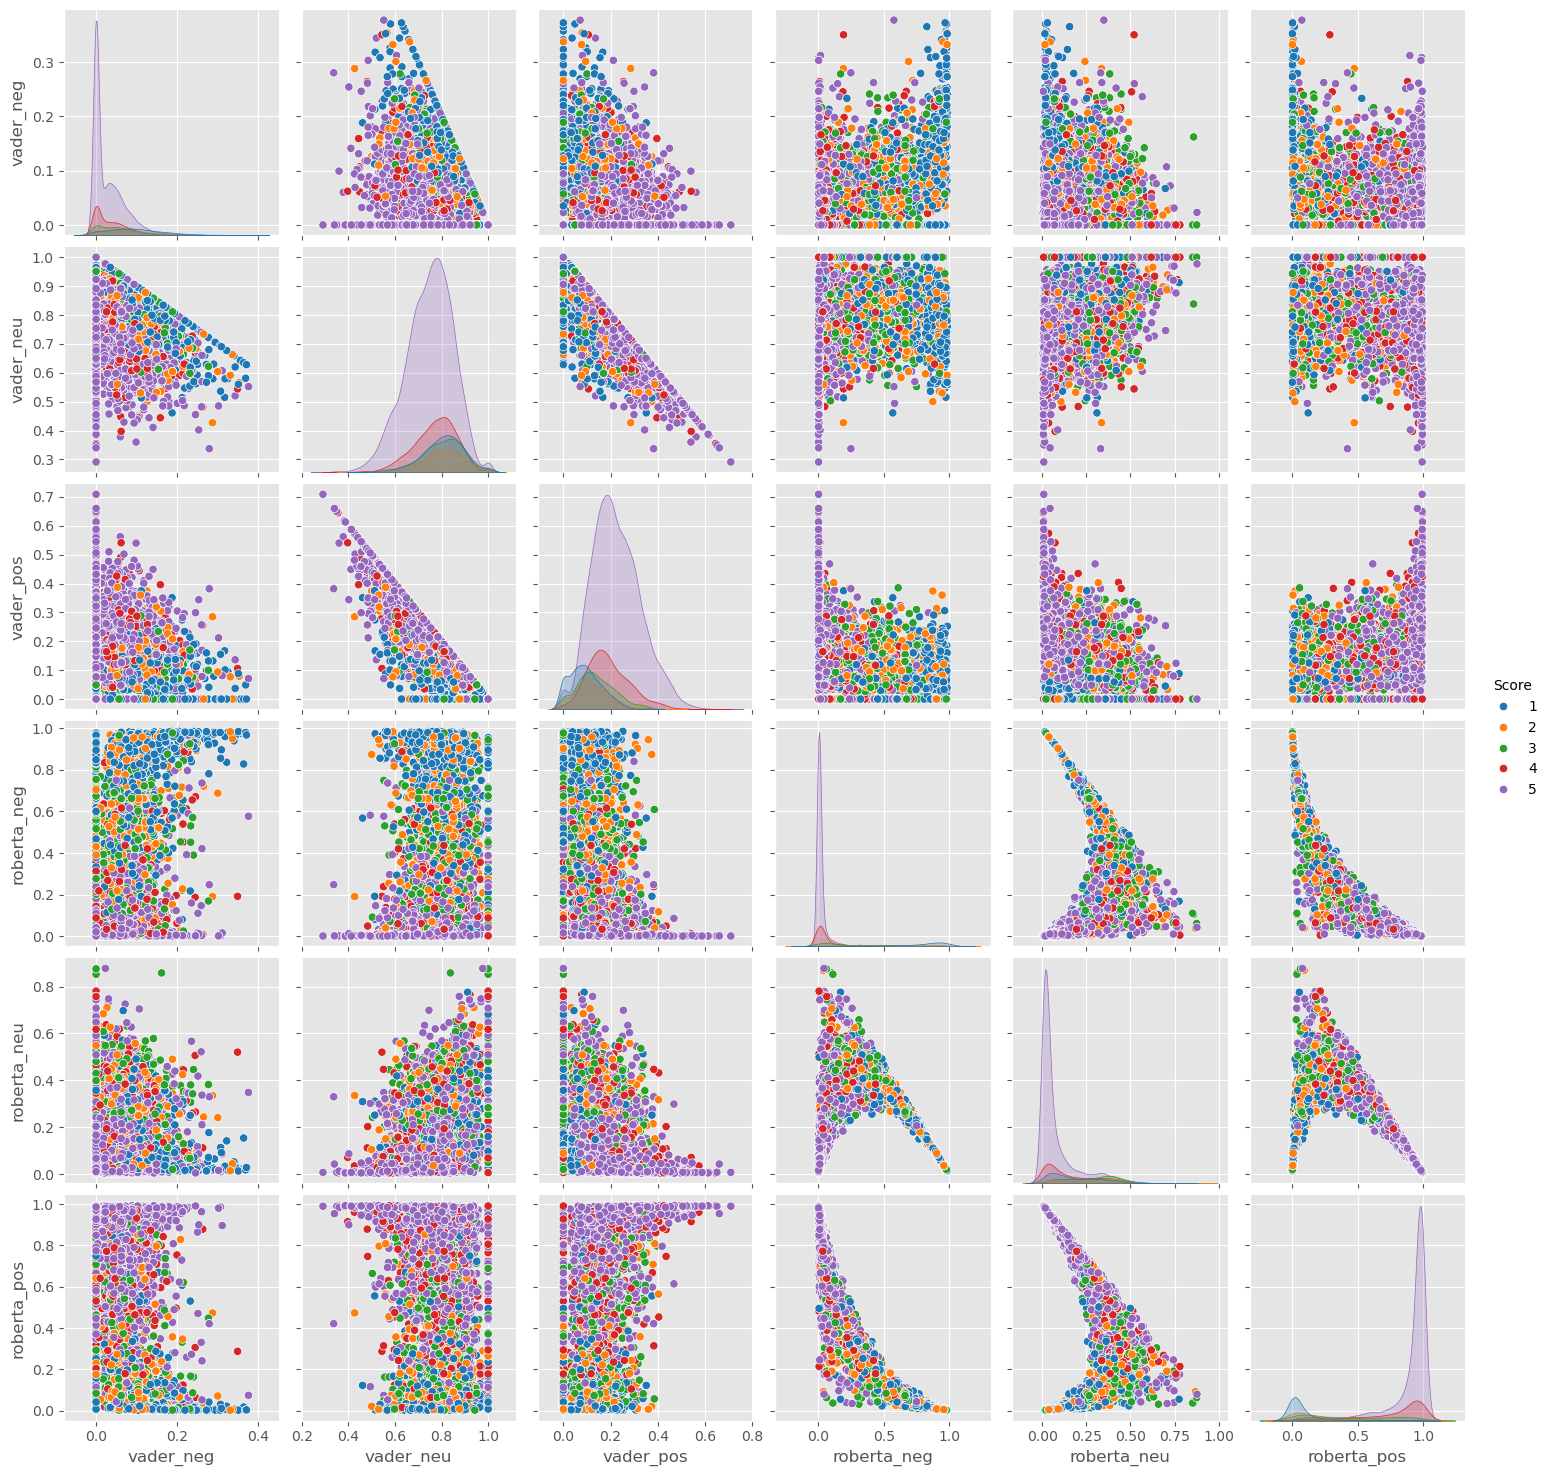

In [66]:
sns.pairplot(data = results_df, 
             vars = ['vader_neg', 'vader_neu', 'vader_pos', 
                    'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue = 'Score',
            palette = 'tab10')
plt.show()

# Review Examples

In [107]:
#positive sentiment 1 star review
print(results_df.query('Score == 1').sort_values('roberta_pos', ascending = False)['Text'].values[0]) #Roberta Model
print(results_df.query('Score == 1').sort_values('vader_pos', ascending = False)['Text'].values[0]) #Vader Model

Bisquick GF is easy to use. Pancakes and muffins are very<br />tasty. The product is quick and easy to use. It makes my day.  Gram
This flavor is horrible.  There are many other flavors much better.  Hawaiian Hazelnut is great!  Breakfast in Bed is AWesome!


In [109]:
#Negative sentiment 5 star review
print(results_df.query('Score == 5').sort_values('roberta_neg', ascending = False)['Text'].values[0]) #Roberta Model
print(results_df.query('Score == 5').sort_values('vader_neg', ascending = False)['Text'].values[0]) #Vader Model

They have a bad taste,i finish giving them away because my son started to cry everytime i tried to give these.I prefer Beech nut or Gerber.Yuck!
My two cats must not be interested in grass, because it grew but they ignored it. Had no problems growing it.
